sample44_leaf_quarter_res
   compactness: 0.179878416103
   fractal dimension: 1.69553214245 +/- 0.0315981416926
   constant: 147.353596303 +/- 17.1398103485
   normalized count at 25% of max rad: [ 0.24462986]
   normalized count at 50% of max rad: [ 0.59532308]
   normalized count at 75% of max rad: [ 0.90821719]


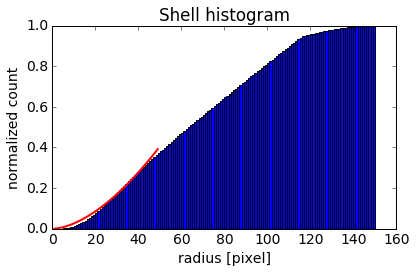

sample41_leaf_half_res_size30
   compactness: 0.5171569217
   fractal dimension: 2.93411358066 +/- 0.0261440220123
   constant: 3.86440795011 +/- 0.354388785652
   normalized count at 25% of max rad: [ 0.14536911]
   normalized count at 50% of max rad: [ 0.72124375]
   normalized count at 75% of max rad: [ 0.98090826]


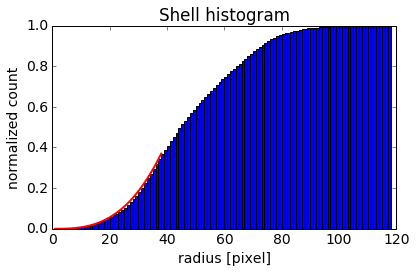

sample38_leaf_quarter_res
   compactness: 0.22657548938
   fractal dimension: 2.15662561347 +/- 0.0581888493798
   constant: 40.8127442575 +/- 8.46879124597
   normalized count at 25% of max rad: [ 0.22012918]
   normalized count at 50% of max rad: [ 0.57080982]
   normalized count at 75% of max rad: [ 0.82391114]


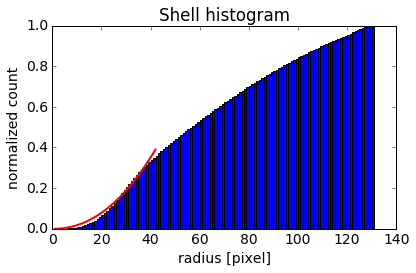

sample36_leaf_quarter_res
   compactness: 0.30922585192


In [ ]:
# calculate various leaf properties based on the segmented images

import glob
from nifti import *
import numpy as np
from pydescriptors.compactness import hz as compactness_hz
from pydescriptors.compactness import bribiesca as compactness_bribiesca
from pydescriptors.helpers import getSphere
from scipy.ndimage.measurements import center_of_mass
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
import pickle
from scipy.optimize import curve_fit

# collect segmented leaf files
files = []
for file in glob.glob('data_files/*leaf*.nii.gz'):
    files.append(file)

    
def func(x, C, D): 
    return C*x**D

# go through the files and calculate properties
for f in files[::-1]:
    leaf = NiftiImage(f).asarray()

    X,Y,Z = leaf.nonzero()
    # see Eq. 4.8 for the definition of compactness:
    # https://ore.exeter.ac.uk/repository/bitstream/handle/10036/3026/MartinezOrtizC.pdf
    print f[11:-7]
    print '   compactness:',compactness_hz(X,Y,Z)
    
    # shell histogram
    #print np.shape(leaf)
    CoM = center_of_mass(leaf)
    
    nr_radii = int(np.max(np.shape(leaf))/2e0)
    radii = np.arange(nr_radii+1)
    x,y,z = np.ogrid[-CoM[0]:np.shape(leaf)[0]-CoM[0], -CoM[1]:np.shape(leaf)[1]-CoM[1],-CoM[2]:np.shape(leaf)[2]-CoM[2]]
    
    #print np.shape(x),np.shape(y),np.shape(z)
    
    count = np.zeros(nr_radii)
    
    for i in range(nr_radii):
        mask_outer = x*x + y*y + z*z <= radii[i+1]**2e0
        count[i] = np.sum(leaf[mask_outer])
        #print i,count[i]
    
    if np.max(count) != np.sum(leaf):
        print 'problem with shell histo'
        print np.max(count), np.sum(leaf)
        raise ValueError
    
    max_rad = np.max(radii[1:][count < np.max(count)])
    
    # fit power law
    [C,D], pcov = curve_fit(func, radii[1:max_rad/3], count[1:max_rad/3],bounds = ([0e0,1e0],[np.inf,3e0]))
    
    perr = np.sqrt(np.diag(pcov))
    
    print '   fractal dimension:',D,'+/-',perr[1]
    print '   constant:',C,'+/-',perr[0]
    print '   normalized count at 25% of max rad:',count[radii[1:] == int(max_rad/4e0)]/np.max(count)
    print '   normalized count at 50% of max rad:',count[radii[1:] == int(max_rad/2e0)]/np.max(count)
    print '   normalized count at 75% of max rad:',count[radii[1:] == int(3e0*max_rad/4e0)]/np.max(count)
    
    
    plt.bar(radii[:-1][count < np.max(count)],1e0*count[count < np.max(count)]/np.max(count),width=1)
    plt.plot(radii[1:max_rad/3],C*radii[1:max_rad/3]**D/np.max(count),'r',linewidth=2)
    plt.xlabel('radius [pixel]')
    plt.ylabel('normalized count')
    plt.title('Shell histogram')
    plt.tight_layout()
    plt.savefig('imgs/shell_histo/shell_histo_'+f[11:-7]+'.png',dpi=100)
    plt.show()
    plt.close()
    
    
    file_name = 'data_files/shell_hist_'+f[11:-7]+'.dat'
    f = open(file_name,'w')
    pickle.dump([count,radii],f)
    f.close()
    
    
    
